In [1]:
import yfinance as yf
import bs4 as bs
import pickle
import requests
import pandas as pd
import json
from dateutil import parser
from datetime import datetime
import os
import time
from pandas.io.json import json_normalize
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import wrds
from datetime import datetime as dt
import numpy as np
import glob, os
import csv
from matplotlib import pyplot as plt
import os.path
from os import path

import yakPak as yP

In [2]:
pd.set_option("display.precision", 8)
%load_ext autoreload
%autoreload 2

In [3]:
# Define start and end of download
# allows for rolling windows
start_download = '2006-04-02'#pd.to_datetime('2009-04-02' , format = '%Y-%m-%d')
end_download = '2021-06-01'#pd.to_datetime('2020-06-15', format = '%Y-%m-%d')

In [4]:
start_date = '2009-06-30'#pd.to_datetime('2009-06-02', format = '%Y-%m-%d') # Define start and end dates
end_date = '2020-02-03'#pd.to_datetime('2020-04-15', format = '%Y-%m-%d')

In [5]:
changes = pd.read_csv('S&P 500 Historical Components & Changes(10-14-2022).csv',
                              header=0,
                              index_col=0,
                              parse_dates=True)

In [6]:
tickers = sorted(set.intersection(*list(changes[start_date:end_date].apply(lambda x: set(x.dropna()), axis=1))))

In [7]:
   
if not path.exists("Export\OHLC_data"):
    data_yf = yf.download(tickers, start=start_download, end=end_download)

    with open('Export/OHLC_data', 'wb') as fh:
        pickle.dump(data_yf, fh)
    
    print('\n dumped \'data_yf\' to pickle as OHLC')
    
elif path.exists("Export\OHLC_data"):
    # load from pickle
    with open("Export\OHLC_data","rb") as fin:
        data_yf = pickle.load(fin)
    #data_yf.index = pd.to_datetime(data_yf.index, format = '%Y-%m-%d)    
    print('loaded OHLC data from pickle as \'data_yf\'')


loaded OHLC data from pickle as 'data_yf'


In [8]:
data_yf = yf.download(tickers, start=start_download, end=end_download)

[*********************100%***********************]  312 of 312 completed

17 Failed downloads:
- VAR: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- COG: No data found, symbol may be delisted
- NBL: No data found, symbol may be delisted
- UTX: No data found, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- LB: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted
- PBCT: No data found, symbol may be delisted
- XLNX: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- ANTM: No data found, symbol may be delisted
- BLL: No data found, symbol may be delisted


In [9]:
#dump to pickle
'''
with open('Export/OHLC_data', 'wb') as fh:
    pickle.dump(data_yf, fh)
    
'''

"\nwith open('Export/OHLC_data', 'wb') as fh:\n    pickle.dump(data_yf, fh)\n    \n"

In [10]:
# load from pickle

#'''
with open("Export/OHLC_data","rb") as fin:
    data_yf = pickle.load(fin)
#'''

In [11]:
#ac = data_yf['Adj Close']
oco = (data_yf['Close'] - data_yf['Open'])/data_yf['Open']
oco.index = pd.to_datetime(oco.index, format = '%Y-%m-%d')

In [12]:
oco

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WY,WYNN,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-01,0.00951009,0.03876346,-0.00022801,0.01099414,0.00139467,0.01245188,0.02392227,0.01008765,0.02679058,0.00908542,...,0.01943576,0.01961600,0.01120603,NaN,0.01175495,0.03317138,0.02832244,0.00972029,0.00925920,0.01629026
2006-06-02,0.01225415,-0.02111452,-0.00159817,0.00069600,0.00103558,0.00058107,-0.03112129,-0.00456926,-0.03129144,0.01140456,...,-0.01015390,-0.02401537,0.00369587,NaN,0.00243905,0.00679615,-0.01339918,-0.00157011,0.00344263,0.01035699
2006-06-05,-0.02719553,-0.01880642,-0.01308840,-0.01255806,0.01690820,-0.03890021,-0.01891251,-0.01518429,-0.02606040,0.00220530,...,-0.02288400,-0.02331828,-0.00476191,NaN,-0.03301126,-0.01661288,-0.01571433,-0.01225302,-0.00326266,-0.01231731
2006-06-06,-0.01590055,-0.00830275,0.00556074,-0.00541693,0.01152543,-0.00729488,0.00215569,0.00461647,0.00627488,-0.00358067,...,-0.01776001,-0.00450589,-0.00211747,NaN,0.00666669,-0.00821423,-0.01008639,0.01140460,0.01648167,0.00219700
2006-06-07,-0.00440528,-0.02562399,-0.00368663,0.00965161,-0.03901301,-0.01707310,-0.00645317,0.00043957,-0.00424573,0.00020053,...,-0.01916830,0.01218280,0.00424628,NaN,-0.02454394,0.01806430,-0.01810289,0.01976282,0.01525129,0.00316873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,-0.00134928,-0.00719761,-0.02649852,0.00338984,0.01214380,-0.00359075,-0.00478265,-0.00999138,0.00412794,-0.01110326,...,0.00026841,-0.01156729,-0.00655419,NaN,-0.02084036,-0.00886261,-0.02338210,-0.00330580,-0.00604340,-0.03163350
2021-05-26,-0.02208371,-0.00086642,-0.00226207,-0.00655205,0.00140246,0.00097730,0.00241212,-0.00786032,0.01312693,0.00202944,...,0.00904496,0.01876781,-0.00280895,NaN,0.01184547,-0.00312918,0.01409052,-0.00248367,-0.01499880,0.01376230
2021-05-27,0.03165306,-0.00917434,-0.00337954,-0.01119656,-0.01330693,0.00012258,-0.00537635,0.01060618,-0.01233415,-0.00452118,...,0.00842104,-0.00225617,-0.01139568,NaN,-0.01131180,-0.00923987,0.00083440,-0.00257479,0.01593944,0.00556038


In [13]:
oco = oco.dropna(axis=0, how='all')
oco = oco.dropna(axis=1)

## Rolling Window Calcs

In [14]:
oco = oco.resample('MS').ffill().dropna()

In [15]:
oco_rolling = oco.rolling(12)

In [16]:
oco_mean = oco_rolling.mean()
oco_std = oco_rolling.std()

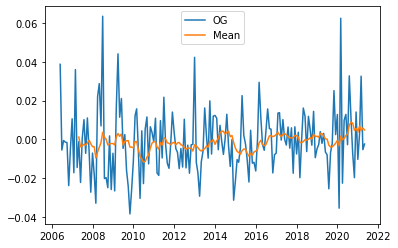

In [17]:
plt.plot(oco['AAPL'], label = 'OG')
plt.plot(oco_mean['AAPL'], label = 'Mean')
plt.legend();

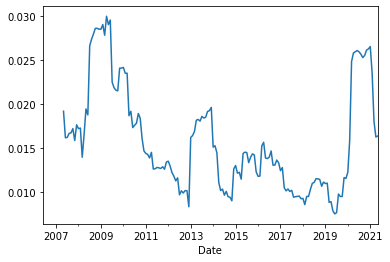

In [18]:
oco_std['AAPL'].plot();

## Augmented Dickey Fuller Test 

In [19]:
# determines if time series is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller

In [20]:
adf_results = adfuller(oco['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))
    

ADF Stats:  -4.877596896604824
p-value:  3.855054498254668e-05
Critical Value (1%): -3.469
Critical Value (5%): -2.879
Critical Value (10%): -2.576


## Detrending

In [21]:
#oco = data_yf['Adj Close']

In [22]:
oco_log = (abs(np.log(abs(oco)**0.5))**2)

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [23]:
oco_log = oco_log.replace([np.inf, -np.inf], np.nan).ffill()
oco_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-01,5.41819207,2.64107560,17.58172168,5.08591019,10.80798713,4.80899348,3.48372034,5.28182199,3.27556583,5.52504892,...,8.53373967,3.88216178,3.86399570,5.04295131,4.93613025,2.90032458,3.17570365,5.36742305,5.48060296,4.23780913
2006-07-01,5.41819207,6.74113625,5.11547864,4.52730634,4.41986417,6.11797963,6.34090096,10.48226997,5.64642767,6.85559245,...,5.10884855,7.21910264,5.27258646,14.28664854,3.75428813,4.71009270,5.83691211,6.74941977,3.69531659,6.10811819
2006-08-01,5.41238114,13.79128694,10.80268636,11.13256820,9.48581096,4.03283992,4.63609229,4.86290205,5.70570963,6.03163581,...,6.60282560,4.95763431,3.17419417,5.30188933,4.55852622,5.90130545,5.15716284,6.53478741,4.19578555,7.52874015
2006-09-01,3.83574611,10.65773506,3.69900786,5.59724612,8.08462851,4.32610906,4.59218450,4.81027498,3.51254327,6.91081482,...,5.30189421,13.50507686,6.86663482,10.69797413,7.85006566,6.36136867,10.93180863,6.67402059,7.44982199,13.56171103
2006-10-01,5.44684231,10.19343237,14.91326603,5.67849391,4.02521148,6.24217887,14.23513389,17.90263074,7.22806972,4.73143721,...,6.61020461,5.50105459,3.20850390,4.89746527,11.33359610,7.01448058,6.62249268,5.71590875,6.25984620,4.84444896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,5.93546703,5.21924488,5.20336677,4.85336881,7.43777176,5.71213521,6.01985329,4.92208562,3.71249154,5.22196916,...,15.86776413,7.32788693,14.20790357,4.55660953,6.53125662,4.33866135,4.03503936,10.25202409,4.45411478,6.74172337
2021-02-01,11.42217779,8.51934233,3.88994942,6.68432667,4.18684491,3.48826177,6.01985329,6.35033827,3.72414035,10.55289388,...,4.95824977,3.85234651,5.73285630,8.18491491,4.48376170,18.45842583,1.94287493,5.82202435,6.43396221,6.51078133
2021-03-01,4.96156946,2.92755262,4.84229844,5.28277132,5.72426144,5.39319161,10.07793997,5.33854289,4.30648390,5.90412196,...,10.36914327,3.96989652,3.27941377,15.97043564,11.19897505,3.33386850,5.58796293,7.12258485,5.34451381,4.05348544


In [24]:
oco_log_ma = oco_log.rolling(2).mean().ffill()

In [25]:
oco_log_ma

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-01,5.41819207,4.69110592,11.34860016,4.80660827,7.61392565,5.46348655,4.91231065,7.88204598,4.46099675,6.19032069,...,6.82129411,5.55063221,4.56829108,9.66479992,4.34520919,3.80520864,4.50630788,6.05842141,4.58795977,5.17296366
2006-08-01,5.41528660,10.26621159,7.95908250,7.82993727,6.95283756,5.07540978,5.48849662,7.67258601,5.67606865,6.44361413,...,5.85583708,6.08836848,4.22339031,9.79426893,4.15640717,5.30569907,5.49703748,6.64210359,3.94555107,6.81842917
2006-09-01,4.62406362,12.22451100,7.25084711,8.36490716,8.78521973,4.17947449,4.61413840,4.83658852,4.60912645,6.47122531,...,5.95235990,9.23135558,5.02041450,7.99993173,6.20429594,6.13133706,8.04448573,6.60440400,5.82280377,10.54522559
2006-10-01,4.64129421,10.42558371,9.30613695,5.63787001,6.05491999,5.28414397,9.41365920,11.35645286,5.37030650,5.82112602,...,5.95604941,9.50306572,5.03756936,7.79771970,9.59183088,6.68792462,8.77715065,6.19496467,6.85483410,9.20308000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,4.93746017,4.87741258,4.74013221,5.52826513,7.00482851,6.30973137,8.19665339,6.78142958,4.53147515,6.99356039,...,11.15354690,9.10371316,11.17085649,4.75320011,5.72879194,4.12317423,5.23152438,8.72321713,3.78870431,5.67485500
2021-02-01,8.67882241,6.86929360,4.54665809,5.76884774,5.81230833,4.60019849,6.01985329,5.63621194,3.71831595,7.88743152,...,10.41300695,5.59011672,9.97037994,6.37076222,5.50750916,11.39854359,2.98895714,8.03702422,5.44403850,6.62625235
2021-03-01,8.19187363,5.72344748,4.36612393,5.98354899,4.95555317,4.44072669,8.04889663,5.84444058,4.01531212,8.22850792,...,7.66369652,3.91112151,4.50613503,12.07767527,7.84136837,10.89614717,3.76541893,6.47230460,5.88923801,5.28213339


In [26]:
oco_detrend = oco_log - oco_log_ma
oco_detrend.dropna(inplace = True)

In [27]:
#mean and std of detrended data
oco_detrend_rolling = oco_detrend.rolling(12)
oco_detrend_ma = oco_detrend_rolling.mean()
oco_detrend_std = oco_detrend_rolling.std()

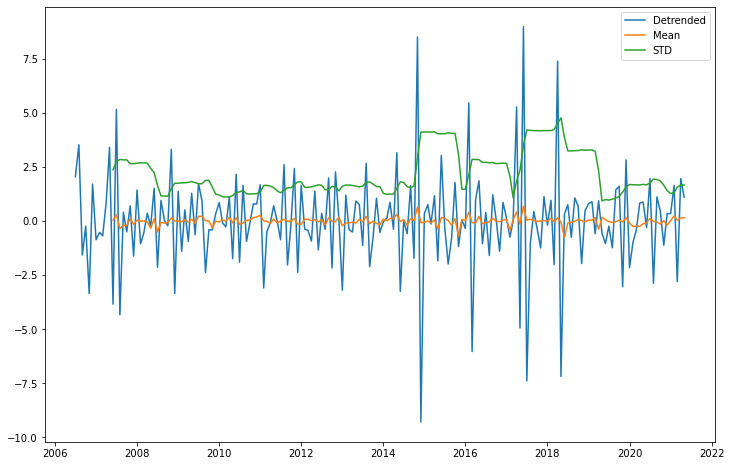

In [28]:
plt.figure(figsize=(12,8))
plt.plot(oco_detrend['AAPL'], label = 'Detrended')
plt.plot(oco_detrend_ma['AAPL'], label = 'Mean')
plt.plot(oco_detrend_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [29]:
oco_detrend['AAPL']

Date
2006-07-01    2.05003033
2006-08-01    3.52507534
2006-09-01   -1.56677594
2006-10-01   -0.23215134
2006-11-01   -3.35481488
                 ...    
2021-01-01    0.34183230
2021-02-01    1.65004873
2021-03-01   -2.79589485
2021-04-01    1.95931972
2021-05-01    1.10784638
Freq: MS, Name: AAPL, Length: 179, dtype: float64

In [30]:
adf_results = adfuller(oco_detrend['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Stats:  -8.456058439377335
p-value:  1.61373511808374e-13
Critical Value (1%): -3.469
Critical Value (5%): -2.879
Critical Value (10%): -2.576


In [31]:
oco_detrend = oco_detrend[start_date:end_date]

In [32]:
#export detrended adjClose
oco_detrend.T.to_csv('Export/oco_detrend.csv') 

## Differencing

In [33]:
oco_log_diff = oco_log.diff(periods=3).dropna()

In [34]:
oco_diff_rolling = oco_log_diff.rolling(12)
oco_diff_ma = oco_diff_rolling.mean()
oco_diff_std = oco_diff_rolling.std()

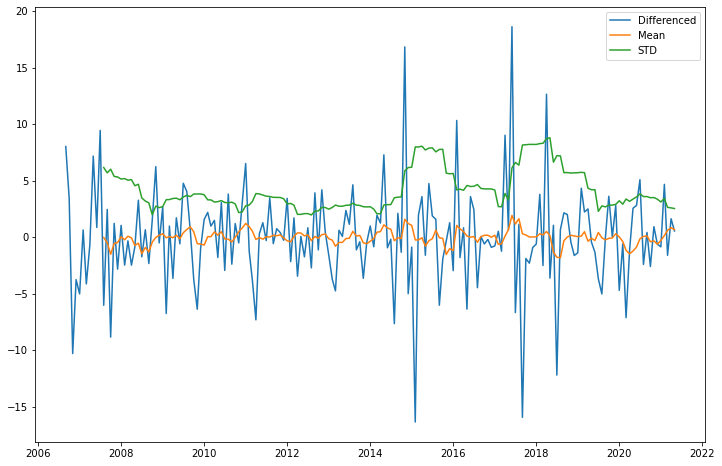

In [35]:
plt.figure(figsize=(12,8))
plt.plot(oco_log_diff['AAPL'], label = 'Differenced')
plt.plot(oco_diff_ma['AAPL'], label = 'Mean')
plt.plot(oco_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [36]:
#export detrended adjClose
oco_log_diff.T.to_csv('Export/oco_diff.csv')

In [37]:
oco_log_diff = oco_log_diff[start_date:end_date]

In [38]:
oco_log_diff

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,2.81890688,4.76826043,-1.34285348,0.36353500,3.06550434,5.82657020,0.98262615,5.10659832,1.16049333,-0.10686838,...,4.63824272,6.57311398,15.05886809,-6.11543694,7.52352336,1.96853867,0.47436553,3.28223595,-0.02035288,1.44410549
2009-08-01,9.53586472,4.03456724,3.15762634,-1.07422215,6.66023904,-0.27526034,7.41295511,0.16390045,10.50652059,2.36184968,...,2.50904683,0.93153043,-5.35516376,0.19232644,10.35838394,4.20660950,1.99185079,2.61638553,0.08298735,-0.21359514
2009-09-01,1.17250890,0.55158515,5.96348984,6.21307111,4.10091846,-0.93170826,-0.34898011,0.58297236,0.69813843,6.04006955,...,2.51901682,0.22042611,1.37976913,6.54611349,1.98538143,-1.04099974,-0.73079913,1.03373528,1.03730561,-2.05633023
2009-10-01,8.09762920,-3.74027474,0.78852490,-1.62875697,-0.88062127,-9.94536658,2.60508615,-2.21410880,1.47757136,0.02916081,...,2.90115791,-5.07880826,-14.80912460,3.01488834,-6.22307420,-2.15258252,-1.27860153,-1.68414349,0.48922858,-1.60036250
2009-11-01,-9.76241851,-6.38024388,-3.50073738,2.73354759,-6.62026790,-3.23085625,-6.61322309,-0.61382861,-11.88486155,-2.84901973,...,-3.53801119,-2.41871521,-0.49928215,-0.27538510,-11.51167895,-2.92605868,-0.98751003,-4.89671497,0.44554432,-2.87106802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,-5.45303717,3.62058745,-1.95802980,-5.15957870,-3.56170451,-1.53195466,-7.58309579,-1.06957954,-0.64111732,2.28139761,...,-0.79013222,-3.53986240,-0.82654406,1.06566974,-2.72873792,3.02972949,-3.79852677,1.69619131,-1.55164893,-3.22784891
2019-11-01,0.00831229,0.02942556,-0.46820339,-0.63023867,-1.96428122,1.05734186,-5.26802526,2.23825670,0.91001316,2.48520498,...,3.24523146,-1.26596883,7.31309064,3.70283302,-0.03857961,1.45588952,-0.58568263,-2.61631953,1.42683714,3.11262560
2019-12-01,2.01497783,2.80665772,-1.70826216,-0.00615429,2.90355876,1.79469570,-1.14431273,10.50182833,-1.60493520,3.32839676,...,8.75079914,-1.35196125,13.87031591,1.46175356,-1.31588757,1.97192959,-1.37803487,4.26144141,-1.84104406,-9.06452604


## Seasonal Decomposition

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
oco_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-01,5.41819207,2.64107560,17.58172168,5.08591019,10.80798713,4.80899348,3.48372034,5.28182199,3.27556583,5.52504892,...,8.53373967,3.88216178,3.86399570,5.04295131,4.93613025,2.90032458,3.17570365,5.36742305,5.48060296,4.23780913
2006-07-01,5.41819207,6.74113625,5.11547864,4.52730634,4.41986417,6.11797963,6.34090096,10.48226997,5.64642767,6.85559245,...,5.10884855,7.21910264,5.27258646,14.28664854,3.75428813,4.71009270,5.83691211,6.74941977,3.69531659,6.10811819
2006-08-01,5.41238114,13.79128694,10.80268636,11.13256820,9.48581096,4.03283992,4.63609229,4.86290205,5.70570963,6.03163581,...,6.60282560,4.95763431,3.17419417,5.30188933,4.55852622,5.90130545,5.15716284,6.53478741,4.19578555,7.52874015
2006-09-01,3.83574611,10.65773506,3.69900786,5.59724612,8.08462851,4.32610906,4.59218450,4.81027498,3.51254327,6.91081482,...,5.30189421,13.50507686,6.86663482,10.69797413,7.85006566,6.36136867,10.93180863,6.67402059,7.44982199,13.56171103
2006-10-01,5.44684231,10.19343237,14.91326603,5.67849391,4.02521148,6.24217887,14.23513389,17.90263074,7.22806972,4.73143721,...,6.61020461,5.50105459,3.20850390,4.89746527,11.33359610,7.01448058,6.62249268,5.71590875,6.25984620,4.84444896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,5.93546703,5.21924488,5.20336677,4.85336881,7.43777176,5.71213521,6.01985329,4.92208562,3.71249154,5.22196916,...,15.86776413,7.32788693,14.20790357,4.55660953,6.53125662,4.33866135,4.03503936,10.25202409,4.45411478,6.74172337
2021-02-01,11.42217779,8.51934233,3.88994942,6.68432667,4.18684491,3.48826177,6.01985329,6.35033827,3.72414035,10.55289388,...,4.95824977,3.85234651,5.73285630,8.18491491,4.48376170,18.45842583,1.94287493,5.82202435,6.43396221,6.51078133
2021-03-01,4.96156946,2.92755262,4.84229844,5.28277132,5.72426144,5.39319161,10.07793997,5.33854289,4.30648390,5.90412196,...,10.36914327,3.96989652,3.27941377,15.97043564,11.19897505,3.33386850,5.58796293,7.12258485,5.34451381,4.05348544


In [41]:
oco_residual = oco_log.apply(lambda x: seasonal_decompose(x, model = 'additive', period = 12).resid, axis = 0).dropna()


In [42]:
oco_residual = oco_residual[start_date:end_date]

In [43]:
#export detrended adjClose
oco_residual.T.to_csv('Export/oco_resid.csv')

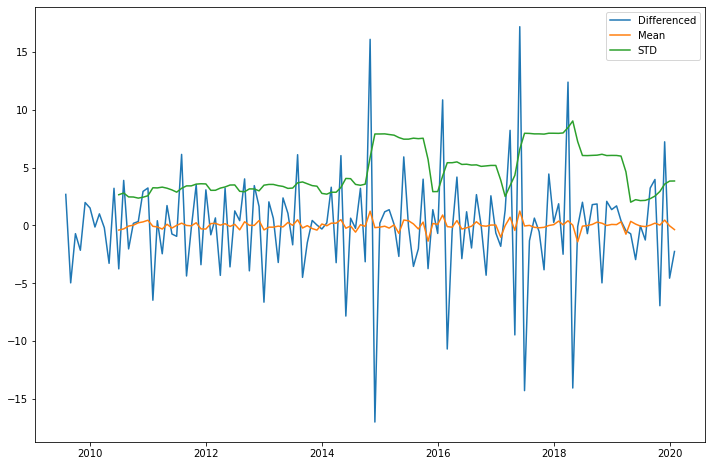

In [44]:
oco_log_diff = oco_residual.diff().dropna()

#mean and std of differenced data
oco_diff_rolling = oco_log_diff.rolling(12)
oco_diff_ma = oco_diff_rolling.mean()
oco_diff_std = oco_diff_rolling.std()

# plot the stationary data
plt.figure(figsize=(12,8))
plt.plot(oco_log_diff['AAPL'], label = 'Differenced')
plt.plot(oco_diff_ma['AAPL'], label = 'Mean')
plt.plot(oco_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');